# Importing the libraries

In [19]:
from google.colab import drive
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial.distance import correlation
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the dataset, Preprocessing, and Visualization

## Toy example

In [32]:
# toy example
smpl_ratings={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 3.5},
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0,
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0},
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

## MovieLens Dataset

The MovieLens dataset can be downloaded from https://grouplens.org/datasets/movielens/1m/. [1]

Some of the data visualizations are derived from a code on Kaggle: https://www.kaggle.com/code/robinmanchanda/eda-and-data-visualization. [2]

### Movies.csv

In [21]:
movies_df = pd.read_csv('/content/drive/MyDrive/ml-1m/movies.csv',sep=';', encoding='latin-1')
print('Shape of this dataset :',movies_df.shape)
movies_df.head()

Shape of this dataset : (3883, 3)


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_df.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

Movies dataframe has no null value.

In [5]:
print('The total number of movies in the dataset : {}'.format(len(movies_df['movieId'].unique())))

The total number of movies in the dataset : 3883


In [ ]:
print('The total number of unique movie titles in the dataset : {}'.format(len(movies_df['title'].unique())))

The total number of unique movie titles in the dataset : 3865


In [ ]:
movies_df.drop_duplicates(subset='title', inplace=True, keep='first')

### Ratings.csv

In [22]:
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-1m/ratings.csv',sep=';')
print('Shape of this dataset :',ratings_df.shape)
ratings_df.head()

Shape of this dataset : (1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
ratings_df['rating'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

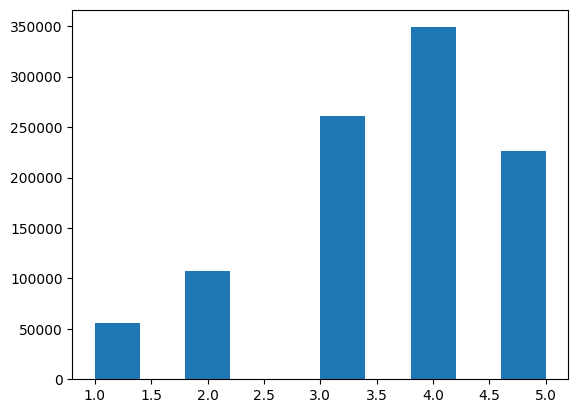

In [ ]:
plt.hist(ratings_df['rating'])
plt.show()

In [ ]:
circlePlot = ratings_df["rating"].value_counts().reset_index()
circlePlot.columns = ["rating", "percent"]
circlePlot["percent"] /= ratings_df.shape[0]

fig = px.pie(circlePlot,
            names="rating",
            values="percent",
            title = "Rating Percentage",
            width = 800,
            height=500)
fig.show()

In [ ]:
print('The number of movies which are rated by at least one user : {}'.format(len(ratings_df['movieId'].unique())))

The number of movies which are rated by at least one user : 3706


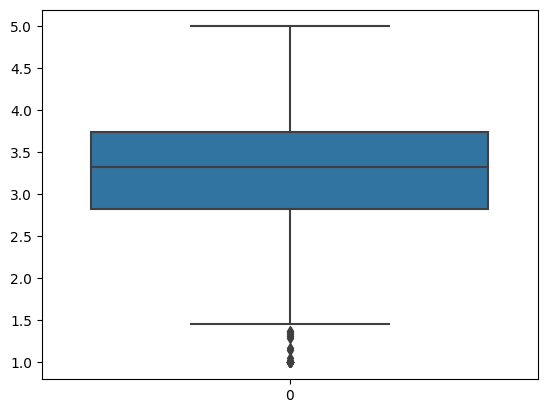

In [ ]:
tmp_df = ratings_df.groupby('movieId').mean()['rating']
tmp_df = pd.DataFrame(tmp_df, columns=['rating']).reset_index()

sns.boxplot(tmp_df['rating'], orient='v')
plt.show()

Extracting the year from the movie titles:

In [ ]:
tmp_df2 = pd.merge(movies_df, tmp_df, on='movieId', how='left')
tmp_df2['Year'] = tmp_df2['title'].str.extract('.*\((.*)\).*')
tmp_df2['Year'].replace(['Das Millionenspiel','Bicicleta, cullera, poma','2007-','2009– ', '1975-1979', '1983)'], value=[np.nan, np.nan, '2007', '2009', '1975', '1983' ], inplace=True)

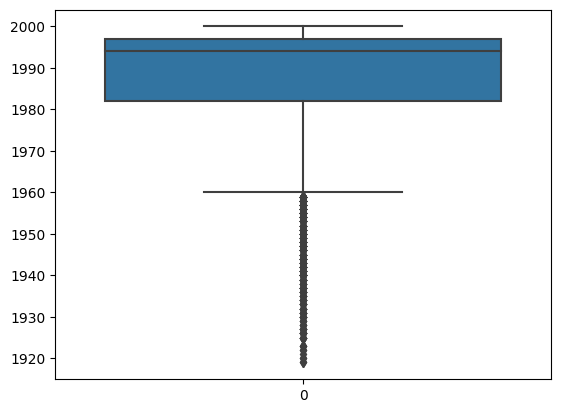

In [ ]:
sns.boxplot(tmp_df2['Year'].dropna().astype('int64'), orient='v')
plt.show()

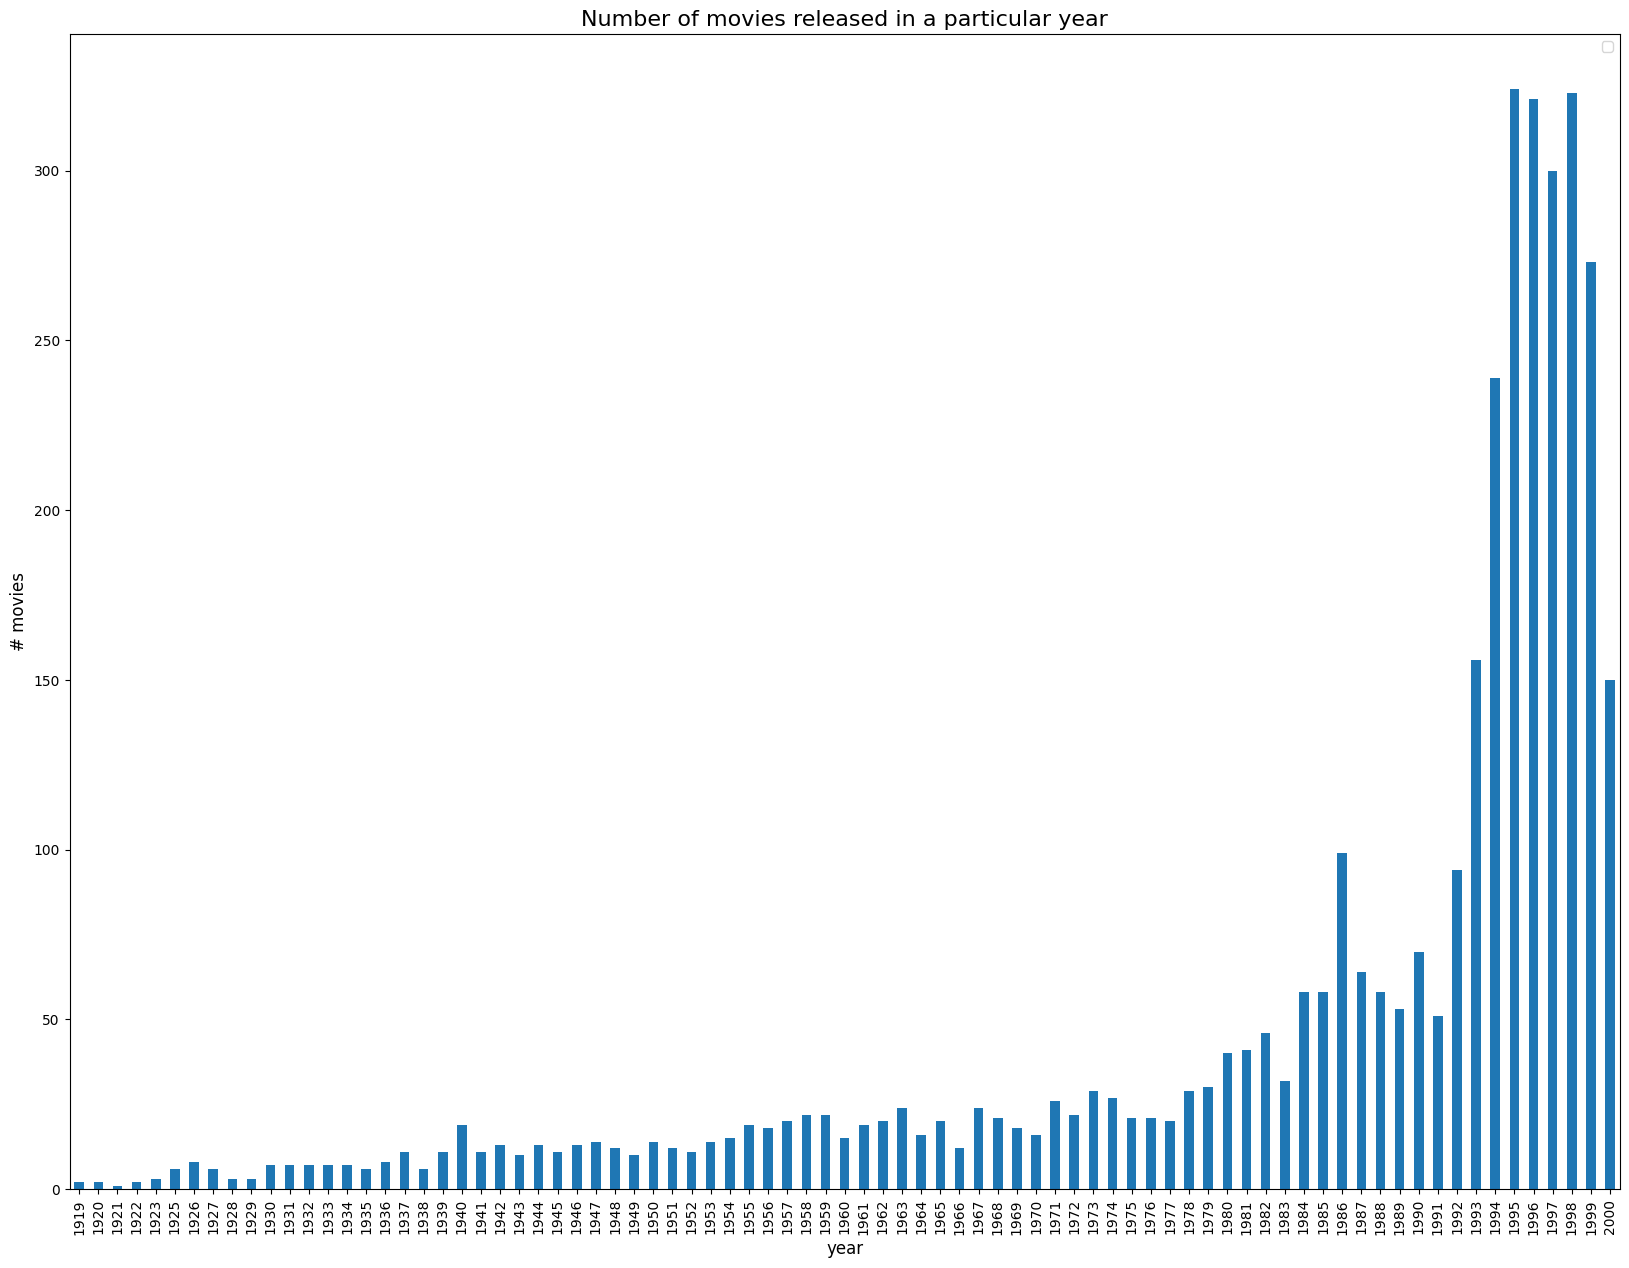

In [ ]:
tmp_df3 = tmp_df2[['Year', 'movieId']].groupby('Year').count()
tmp_df3.rename(mapper={'movieId': 'movies/year'}, inplace= True, axis=1)

tmp_df3.plot.bar(figsize=(20,15))
plt.xlabel('year', fontsize=12)
plt.ylabel('# movies', fontsize=12)
plt.title('Number of movies released in a particular year', fontsize=16)
plt.legend('')
plt.show()

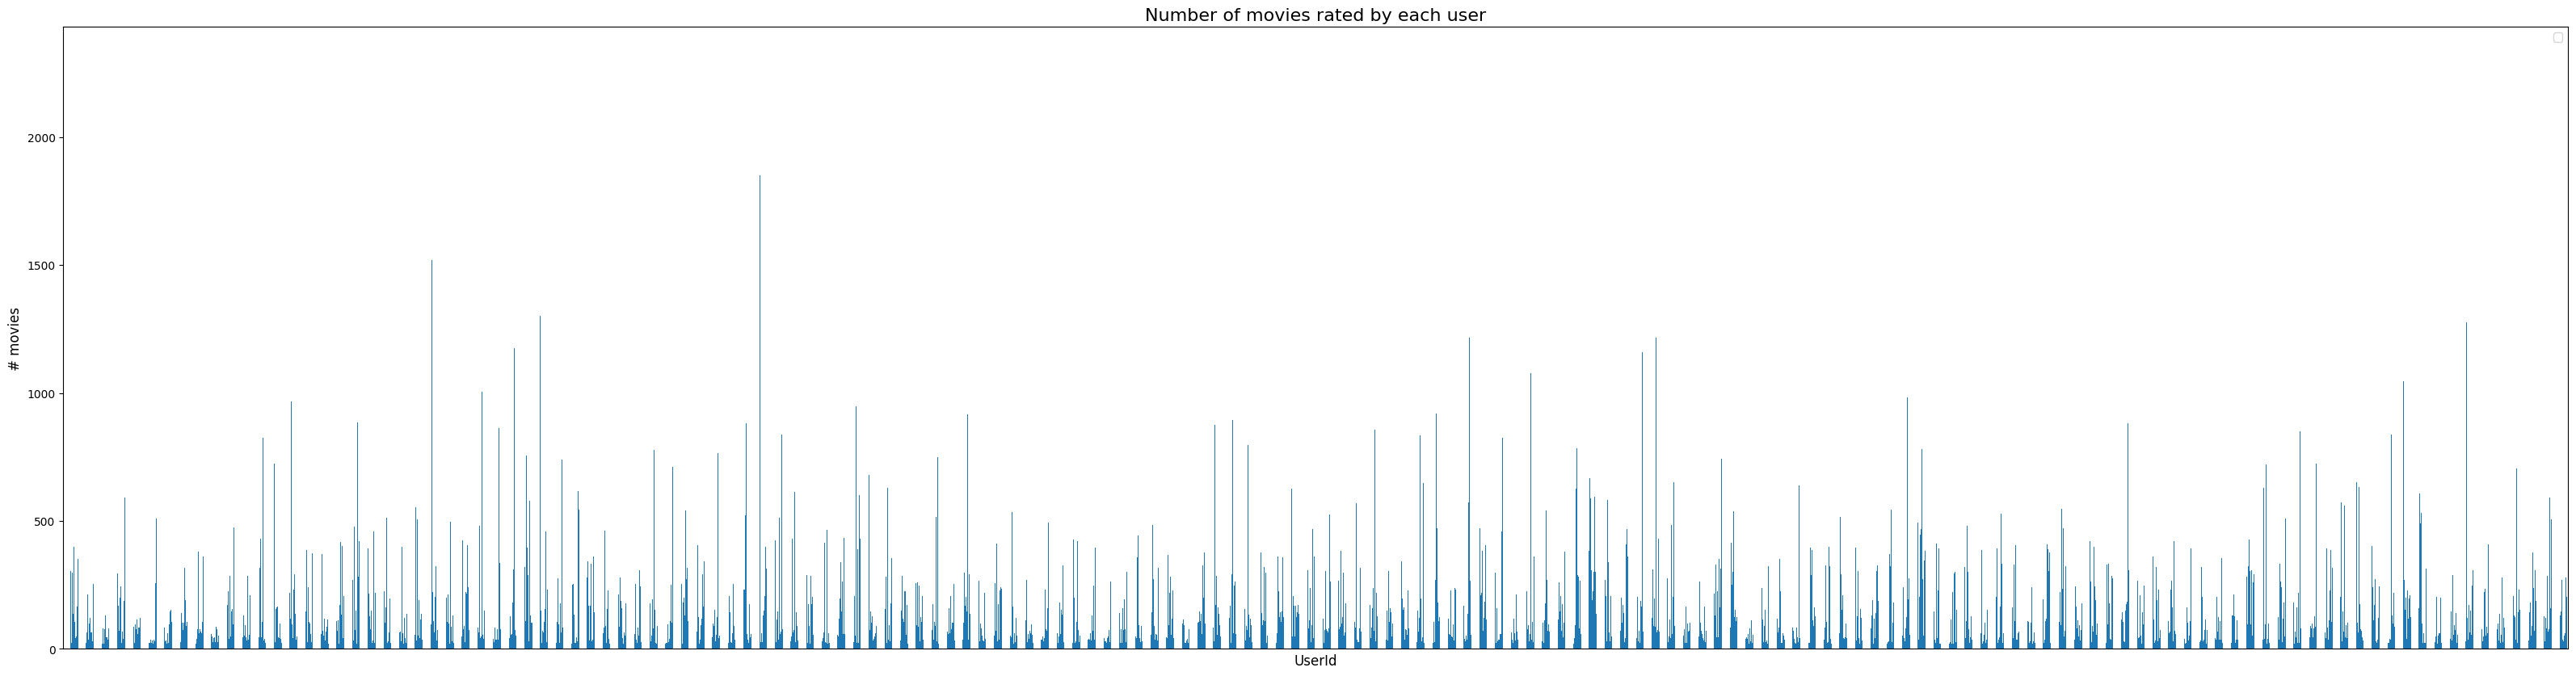

In [ ]:
tmp_df4 = ratings_df[['userId', 'movieId']].groupby('userId').count()
tmp_df4.rename(mapper={'movieId': 'ratings/user'}, inplace= True, axis=1)

tmp_df4.plot.bar(figsize=(40,10))
plt.xlabel('UserId', fontsize=12)
plt.ylabel('# movies', fontsize=12)
plt.title('Number of movies rated by each user', fontsize=16)
plt.legend('')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [ ]:
tmp_df4['ratings/user'].max()
# tmp_df4['ratings/user'].min()

2314

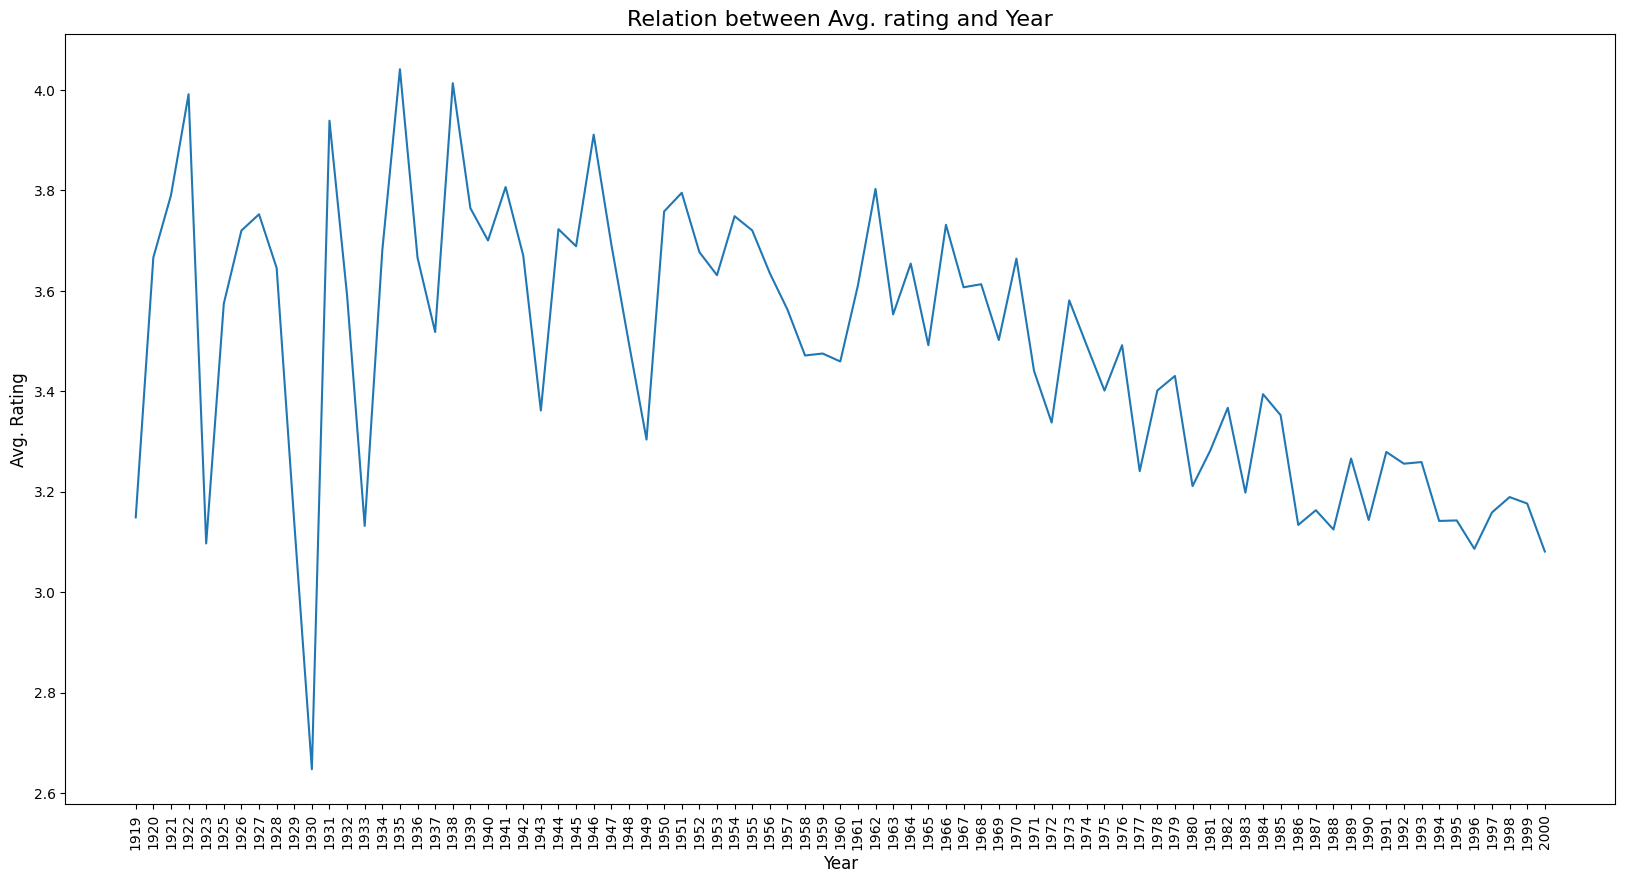

In [ ]:
plt.figure(figsize=(20,10))
year = tmp_df2['Year'].dropna().astype('int64', copy= True).sort_values().unique().tolist()
year = list(map(str, year))
l = list(tmp_df2.groupby('Year')['rating'].mean().to_numpy())
sns.lineplot(x=year, y=l)
plt.xticks(rotation='vertical')
plt.title('Relation between Avg. rating and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg. Rating', fontsize=12)
plt.show()

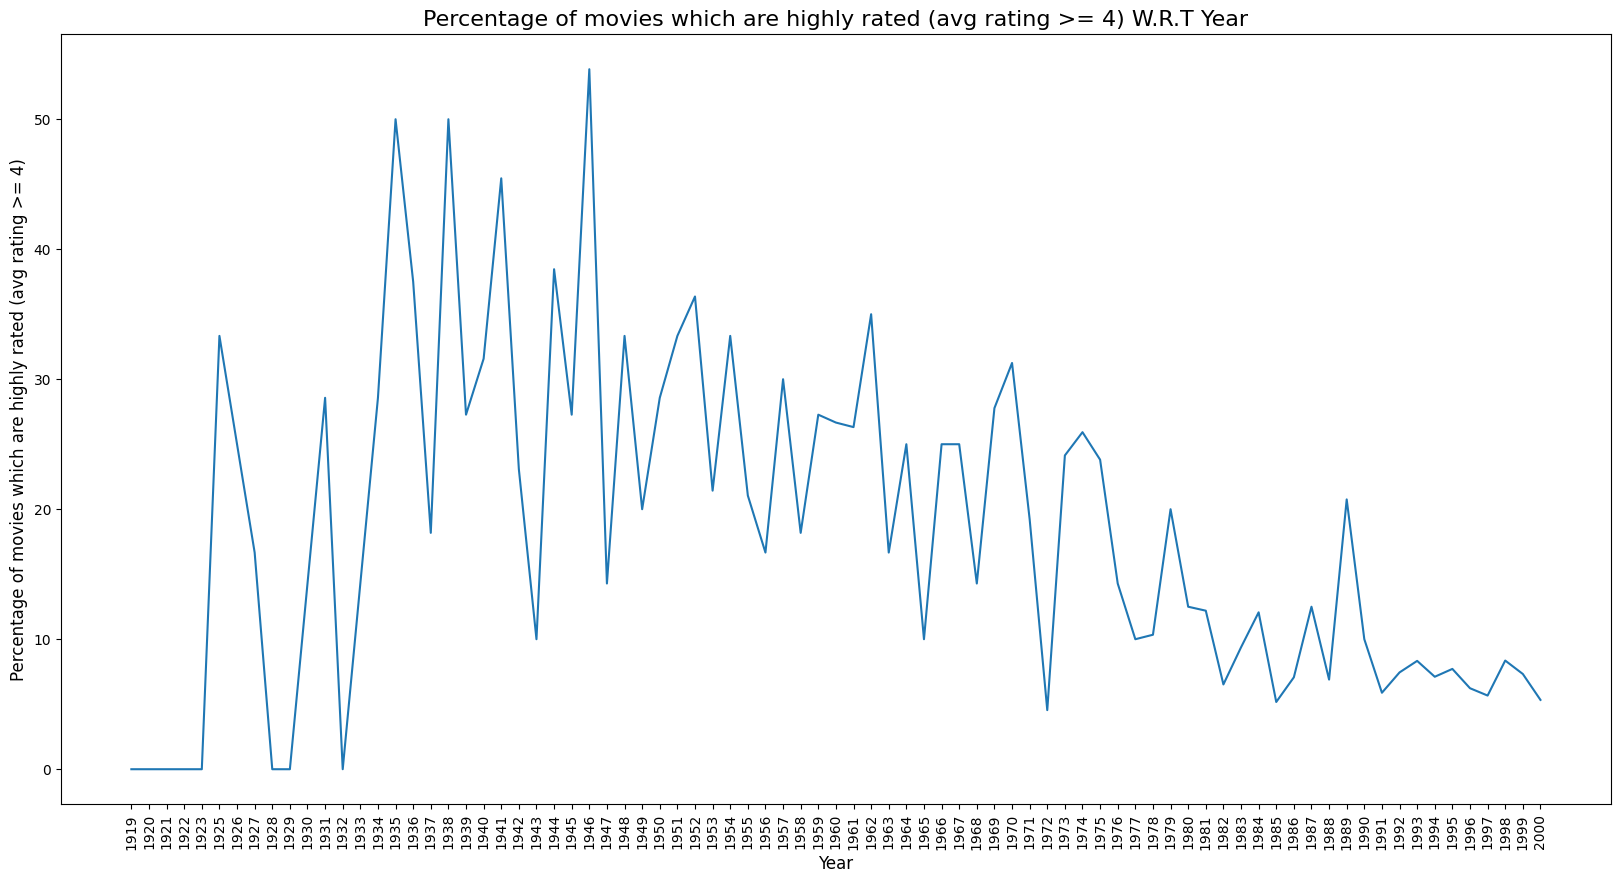

In [ ]:
# Loop to find Percentage of movies which are highly rated (avg rating >= 4) for all years
popular_movies = []
for i in range(len(year)):
  le = len(tmp_df2[(tmp_df2['rating'] >= 4) & (tmp_df2['Year'] == year[i])])
  if le > 0:
    popular_movies.append((le/(tmp_df3.loc[year[i]]['movies/year']))*100)
  else:
    popular_movies.append(0)

plt.figure(figsize=(20,10))
plt.plot(year, popular_movies)
plt.xticks(rotation='vertical')
plt.xlabel('Year', fontsize=12)
plt.ylabel("Percentage of movies which are highly rated (avg rating >= 4)", fontsize=12)
plt.title('Percentage of movies which are highly rated (avg rating >= 4) W.R.T Year', fontsize=16)
plt.show()

### Users.csv

In [23]:
users_df = pd.read_csv('/content/drive/MyDrive/ml-1m/users.csv',sep=';')
print('Shape of this dataset :',users_df.shape)
users_df.head()

Shape of this dataset : (6040, 5)


,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455


In [6]:
def loadMovieLens(movies_df, ratings_df):
  # Get movie titles
  movies = {}
  for i in range(movies_df.shape[0]):
    id = movies_df.at[i, 'movieId']
    title = movies_df.at[i, 'title']
    movies[id] = title

  # Load data
  ratings = {}
  for i in range(ratings_df.shape[0]):
    userId = ratings_df.at[i, 'userId']
    movieId = ratings_df.at[i, 'movieId']
    rating = ratings_df.at[i, 'rating']
    ratings.setdefault(userId,{})
    ratings[userId][movies[movieId]] = float(rating)
  return ratings

In [7]:
movies_df = pd.read_csv('/content/drive/MyDrive/ml-1m/movies.csv',sep=';' ,encoding='latin-1')
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-1m/ratings.csv',sep=';')
ratings = loadMovieLens(movies_df, ratings_df)

Some of the following functions have been selected from or inspired by the  textbook [3].

# Similarity metrics

## Euclidean Distance Similarity

In [8]:
# Returns a distance-based similarity score for person1 and person2
def euclidean_distance_sim(ratings, person1, person2):
  # Get the list of shared_items
  si = {}
  for item in ratings[person1]:
    if item in ratings[person2]: si[item] = 1

  # if they have no ratings in common, return 0
  if len(si) == 0: return 0

  # Add up the squares of all the differences
  sum_of_squares = sum([pow(ratings[person1][item] - ratings[person2][item], 2)
                      for item in ratings[person1] if item in ratings[person2]])

  return 1 / (1 + sqrt(sum_of_squares))

## Manhattan Distance Similarity

In [9]:
def manhattan_distance_sim(ratings, person1, person2):
  # Get the list of shared_items
  si = {}

  for item in ratings[person1]:
    if item in ratings[person2]: si[item] = 1

  # if they have no ratings in common, return 0
  if len(si) == 0: return 0

  # Add up the absulute value of all the differences
  sum_of_abs = sum([abs(ratings[person1][item] - ratings[person2][item]) for item in si])

  return 1 / (1 + sum_of_abs)

## Cosine Similarity

In [10]:
def cosine_sim(ratings, person1, person2):
  a = 0
  for item in ratings[person1]:
    if item in ratings[person2]:
      a += ratings[person1][item] * ratings[person2][item]

  # if they have no ratings in common, return 0
  if a == 0: return 0

  b = 0
  c = 0
  for item in ratings[person1]:
    b += ratings[person1][item] * ratings[person1][item]
  b = sqrt(b)

  for item in ratings[person2]:
    c += ratings[person2][item] * ratings[person2][item]
  c = sqrt(c)

  return a/(b*c)

## Pearson Correlation Similarity

The formula for the Pearson Correlation Similarity can also be written as:
pearson_corr_formula.svg

In [11]:
# Returns the Pearson correlation coefficient for p1 and p2
def pearson_correlation_sim(ratings, p1, p2):
  # Get the list of mutually rated items
  si = {}
  for item in ratings[p1]:
    if item in ratings[p2]: si[item] = 1

  # if they are no ratings in common, return 0
  if len(si) == 0: return 0

  # Sum calculations
  n = len(si)

  # Sums of all the preferences
  sum1 = sum([ratings[p1][it] for it in si])
  sum2 = sum([ratings[p2][it] for it in si])

  # Sums of the squares
  sum1Sq = sum([pow(ratings[p1][it], 2) for it in si])
  sum2Sq = sum([pow(ratings[p2][it], 2) for it in si])

  # Sum of the products
  pSum = sum([ratings[p1][it] * ratings[p2][it] for it in si])

  # Calculate r (Pearson score)
  num = pSum - (sum1 * sum2 / n)  # numerator
  den = sqrt((sum1Sq - pow(sum1, 2) / n) * (sum2Sq - pow(sum2, 2) / n))   # denominator
  if den == 0: return 0

  # r= abs(num/den)
  r = num/den

  return r

In [ ]:
for p in smpl_ratings:
  if p != 'Toby':
    print("similarity between Toby and ", p, ":", pearson_correlation_sim(smpl_ratings, 'Toby', p))

similarity between Toby and  Lisa Rose : 0.9912407071619299
similarity between Toby and  Gene Seymour : 0.38124642583151164
similarity between Toby and  Michael Phillips : -1.0
similarity between Toby and  Claudia Puig : 0.8934051474415647
similarity between Toby and  Mick LaSalle : 0.9244734516419049
similarity between Toby and  Jack Matthews : 0.66284898035987


## Weighted Jaccard Similarity

Weighted Jaccard similarity [4] between two vectors with non-negative entries is defined as:

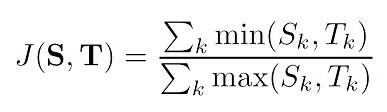

In [12]:
def weighted_jaccard_sim(ratings, person1, person2):
  num = 0   # numerator
  for item in ratings[person1]:
    if item in ratings[person2]:
      num += min(ratings[person1][item], ratings[person2][item])

  # if they have no ratings in common, return 0
  if num == 0: return 0

  den = 0   # denominator
  for item in ratings[person2]:
    if (item not in ratings[person1]):
      den += ratings[person2][item]
  for item in ratings[person1]:
    if item in ratings[person2]:
      den += max(ratings[person1][item], ratings[person2][item])
    else:
      den += ratings[person1][item]

  return num / den

# Utils

In [13]:
# Returns the best matches for person from the ratings dictionary.
# Number of results and similarity function are optional params.
def topMatches(ratings, person, n = 5, similarity = pearson_correlation_sim):
  scores = [(similarity(ratings, person, other), other)
                  for other in ratings if other != person]
  scores.sort()
  scores.reverse()
  return scores[0:n]

In [14]:
def transformRatings(ratings):
  result = {}
  for person in ratings:
    for item in ratings[person]:
      result.setdefault(item, {})

      # Flip item and person
      result[item][person] = ratings[person][item]
  return result

In [15]:
def calculateSimilarItems(ratings, n = 10):
  # Create a dictionary of items showing which other items they
  # are most similar to.
  result = {}

  # Invert the preference matrix to be item-centric
  itemRatings = transformRatings(ratings)

  for item in itemRatings:
    # Find the most similar items to this one
    scores = topMatches(itemRatings, item, n = n, similarity = pearson_correlation_sim)
    result[item] = scores
  return result

# Baseline Collaborative Filtering predictor

In [40]:
def calculate_means(ratings):
  mu = [0, 0]
  mu_u = {}
  mu_i = {}

  for u in ratings:
    mu_u.setdefault(u, [0, 0])

    for it in ratings[u]:
      mu[0] += ratings[u][it]
      mu[1] += 1

      mu_u[u][0] += ratings[u][it]
      mu_u[u][1] += 1

      mu_i.setdefault(it, [0, 0])
      mu_i[it][0] += ratings[u][it]
      mu_i[it][1] += 1

  return mu, mu_u, mu_i

In [41]:
def predict_rating_baselineCF(rating, mu, mu_u, mu_i, returnPrediction=True):
  mu[0] -= rating
  mu[1] -= 1
  mu_u[0] -= rating
  mu_u[1] -= 1
  mu_i[0] -= rating
  mu_i[1] -= 1
  if returnPrediction == True:
    return (mu_u[0]/mu_u[1]) + (mu_i[0]/mu_i[1]) - (mu[0]/mu[1])
  else:
    return (mu[0]/mu[1]), (mu_u[0]/mu_u[1]), (mu_i[0]/mu_i[1])

In [42]:
def topMatches_baselineCF(ratings, user, mu, mu_u, mu_i, n = 5):
  itemRatings = transformRatings(ratings)
  scores = [(predict_rating_baselineCF(ratings[user][item], mu, mu_u[user], mu_u[item]), item)
                    for item in itemRatings if item not in ratings[user]]

  scores.sort( )
  scores.reverse( )
  return scores[0:n]

In [43]:
def baselineCF_rmse(ratings, mu, mu_u, mu_i):
  rmse_sum = 0
  n = 0
  for u in ratings:
    for i in ratings[u]:
      try:  # skip cases in which the user has rated one and only one movie, or the movie is rated by one any one user
        rmse_sum += pow(predict_rating_baselineCF(ratings[u][i], mu, mu_u[u], mu_i[i]) - ratings[u][i], 2)
        n += 1
      except:
        continue
  rmse = sqrt(rmse_sum / n)
  return rmse

In [38]:
mu, mu_u, mu_i = calculate_means(smpl_ratings)
baselineCF_rmse(smpl_ratings, mu, mu_u, mu_i)
# topMatches_baselineCF(smpl_ratings, 'Toby', mu, mu_u, mu_i)

0.8624021175259915

In [44]:
mu, mu_u, mu_i = calculate_means(ratings)
baselineCF_rmse(ratings, mu, mu_u, mu_i)

0.9567754591361076

In [45]:
def calculate_gradientDescent(rating, mu, mu_u, mu_i):
  mu, mu_u, mu_i = predict_rating_baselineCF(rating, mu, mu_u, mu_i, False)
  b_u = mu_u - mu
  b_i = mu_i - mu

  lambda1 = 0.02  # regularization parameter for b_u
  lambda2 = 0.02  # regularization parameter for b_i
  gama = 0.005    # learning rate

  for epoch in range(3):
    b_u += gama * (rating - mu - b_u - b_i - lambda1 * b_u)
    b_i += gama * (rating - mu - b_u - b_i - lambda2 * b_i)

  return mu + b_u + b_i

In [46]:
def baselineGDCF_rmse(ratings, mu, mu_u, mu_i):
  rmse_sum = 0
  n = 0
  for u in ratings:
    for i in ratings[u]:
      try:  # skip cases in which the user has rated one and only one movie, or the movie is rated by one any one user
        rmse_sum += pow(calculate_gradientDescent(ratings[u][i], mu, mu_u[u], mu_i[i]) - ratings[u][i], 2)
        n += 1
      except:
        continue
  rmse = sqrt(rmse_sum / n)
  return rmse

In [47]:
baselineGDCF_rmse(ratings, mu, mu_u, mu_i)

0.8858808436486311

# User-User Collaborative Filtering

In [ ]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def giveRecomUserUser(ratings, person, similarity = pearson_correlation_sim):
  totals = {}
  simSums = {}
  for other in ratings:
    # don't compare me to myself
    if other == person: continue
    sim = similarity(ratings, person, other)

    # ignore scores of zero or lower
    if sim <= 0: continue
    for item in ratings[other]:

      # only score movies I haven't seen yet
      if item not in ratings[person] or ratings[person][item] == 0:
        # Similarity * Score
        totals.setdefault(item, 0)
        totals[item] += ratings[other][item] * sim

        # Sum of similarities
        simSums.setdefault(item, 0)
        simSums[item] += sim

  # Create the normalized list
  rankings = [(total / simSums[item], item) for item, total in totals.items()]

  # Return the sorted list
  rankings.sort()
  rankings.reverse()
  return rankings

In [ ]:
giveRecomUserUser(smpl_ratings, 'Toby')

[(3.3477895267131017, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

In [ ]:
def userUserRMSE(ratings, similarity = pearson_correlation_sim):
  rankings = {}
  n = 0
  for person in ratings:
    totals = {}
    simSums = {}
    for other in ratings:
      # don't compare me to myself
      if other == person: continue
      sim = similarity(ratings, person, other)

      # ignore scores of zero or lower
      if sim <= 0: continue
      for item in ratings[other]:

        # only score movies I have seen before
        if item in ratings[person] and ratings[person][item] != 0:

          # Similarity * Score
          totals.setdefault(item, 0)
          totals[item] += ratings[other][item] * sim

          # Sum of similarities
          simSums.setdefault(item, 0)
          simSums[item] += sim

    if len(ratings[person]) > 1:
      # Create the normalized list
      rankings[person] = {item: total/simSums[item] for item, total in totals.items()}
      n += len(rankings[person])
  rmse = sqrt(sum(sum(pow(rankings[p][i] - ratings[p][i], 2) for i in rankings[p]) for p in rankings) / n)
  # rmse_sum = 0
  # for p in ratings:
  #   for i in ratings[p]:
  #     rmse_sum += pow(rankings[p][i] - ratings[p][i], 2)
  # rmse = sqrt(rmse_sum / n)
  return rmse

In [ ]:
userUserRMSE(smpl_ratings, similarity=euclidean_distance_sim)

0.6842517532537453

In [ ]:
userUserRMSE(smpl_ratings)

0.6522275693695943

In [ ]:
userUserRMSE(ratings, similarity=euclidean_distance_sim)

0.9510262776759091

In [ ]:
userUserRMSE(ratings, similarity=manhattan_distance_sim)

0.9367029854811918

In [ ]:
userUserRMSE(ratings, similarity=cosine_sim)

0.9720040828459882

In [ ]:
userUserRMSE(ratings)

0.8888631849665105

In [ ]:
userUserRMSE(ratings, similarity=weighted_jaccard_sim)

# Item-Item Collaborative Filtering

In [ ]:
def giveRecomItemItem(ratings, itemMatch, user):
  userRatings = ratings[user]
  scores = {}
  totalSim = {}
  # Loop over items rated by this user
  for (item, rating) in userRatings.items():

    # Loop over items similar to this one
    for (similarity, item2) in itemMatch[item]:

      # Ignore if this user has already rated this item
      if item2 in userRatings: continue

      # Weighted sum of rating times similarity
      scores.setdefault(item2, 0)
      scores[item2] += similarity * rating

      # Sum of all the similarities
      totalSim.setdefault(item2, 0)
      totalSim[item2] += similarity

  # Divide each total score by total weighting to get an average
  rankings = [(score / totalSim[item2], item2) for item2, score in scores.items()]

  # Return the rankings from highest to lowest
  rankings.sort( )
  rankings.reverse( )
  return rankings

In [ ]:
itemMatch = calculateSimilarItems(smpl_ratings, 4)
giveRecomItemItem(smpl_ratings, itemMatch, 'Toby')

[(3.610031066802183, 'Lady in the Water'),
 (3.5313950341859766, 'The Night Listener'),
 (2.42450977746756, 'Just My Luck')]

In [ ]:
def itemItemRMSE(ratings, similarity = pearson_correlation_sim):
  itemMatch = {}
  itemRatings = transformRatings(ratings)
  for item in itemRatings:
    scores = topMatches(itemRatings, item, n = len(itemRatings) - 1, similarity = similarity)
    itemMatch[item] = scores

  rankings = {}
  n = 0
  for user in ratings:
    userRatings = ratings[user]
    scores = {}
    totalSim = {}
    # Loop over items rated by this user
    for (item, rating) in userRatings.items():

      # Loop over items similar to this one
      for (sim, item2) in itemMatch[item]:

        # ignore scores of zero or lower
        if sim <= 0: continue

        # only score the items this user has already rated
        if item2 not in userRatings: continue

        # Weighted sum of rating times similarity
        scores.setdefault(item2, 0)
        scores[item2] += sim * rating

        # Sum of all the similarities
        totalSim.setdefault(item2, 0)
        totalSim[item2] += sim

    if len(userRatings) > 1:
      # Divide each total score by total weighting to get an average
      rankings[user] = {item2: score / totalSim[item2] for item2, score in scores.items()}
      n += len(rankings[user])

  rmse = sqrt(sum(sum(pow(rankings[p][i] - ratings[p][i], 2) for i in rankings[p]) for p in rankings) / n)
  return rmse

In [ ]:
itemItemRMSE(smpl_ratings, similarity=euclidean_distance_sim)

1.0318742983361122

In [ ]:
itemItemRMSE(smpl_ratings)

1.1946938276481927

In [ ]:
itemItemRMSE(ratings, similarity=euclidean_distance_sim)

1.0087705929494022

In [ ]:
itemItemRMSE(ratings, similarity=manhattan_distance_sim)

1.0263660949885343

In [ ]:
itemItemRMSE(ratings, similarity=cosine_sim)

1.0011767125407818

In [ ]:
itemItemRMSE(ratings)

0.9258636603770216

In [ ]:
itemItemRMSE(ratings, similarity=weighted_jaccard_sim)

# Evaluation Results

The results are sorted from the lowest to highest RMSE.

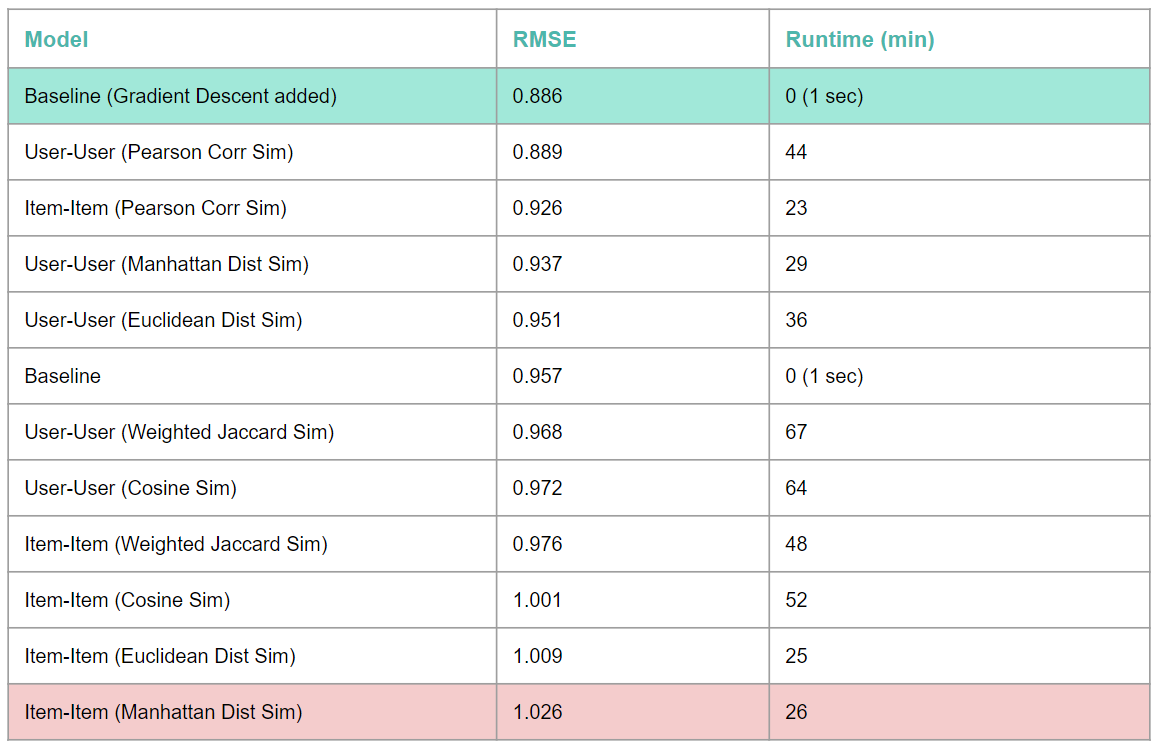

# References

[1] MovieLens 1M Dataset (https://grouplens.org/datasets/movielens/1m/)

[2] EDA and Data Visualization from Kaggle (https://www.kaggle.com/code/robinmanchanda/eda-and-data-visualization)

[3] Segaran, Toby. Programming collective intelligence: building smart web 2.0 applications. " O'Reilly Media, Inc.", 2007.
(https://resources.oreilly.com/examples/9780596529321/-/blob/master/PCI_Code%20Folder/chapter2/recommendations.py)

[4] Ioffe, Sergey. Improved consistent sampling, weighted minhash and l1 sketching. 2010 IEEE international conference on data mining. IEEE, 2010.

[5] Koren, Yehuda, Steffen Rendle, and Robert Bell. Advances in collaborative filtering: Recommender systems handbook, 2021.